In [ ]:
!wget "http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/nyu_depth_images.tar"

!wget "https://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/qa.894.raw.txt"

!wget "http://nlp.stanford.edu/data/glove.6B.zip"

!unzip glove.6B.zip

!tar -xvf nyu_depth_images.tar

--2019-12-06 19:02:11--  http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/nyu_depth_images.tar
Resolving datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)... 139.19.86.170
Connecting to datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)|139.19.86.170|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/nyu_depth_images.tar [following]
--2019-12-06 19:02:16--  https://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/nyu_depth_images.tar
Connecting to datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)|139.19.86.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 431144960 (411M) [application/x-tar]
Saving to: ‘nyu_depth_images.tar’

nyu_depth_images.ta 100%[===================>] 411.17M   109MB/s    in 3.9s    

2019-12-06 19:02:20 (106 MB/s) - ‘nyu_depth_images.tar’ saved [431144960/431144960]

--2019-12-06 19:02:21--  https://datasets.d2.mpi-

In [ ]:
from torch import nn
from torch.autograd import Variable
import torch
import numpy as np
import glob
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import torch.cuda as cuda
import torch.utils.data as torchdata
import torchvision.models as models
import torch.nn.functional as F
import random
from torch.utils.data.sampler import SubsetRandomSampler
import copy
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

glove_path = '/content/glove.6B.300d.txt'


# create word dictionary
def load_glove(path):
    with open(path, encoding="utf8") as f:
        glove = {}
        for line in f.readlines():
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            glove[word] = vector
        return glove


glove = load_glove(glove_path)


def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.from_numpy(weights_matrix)})
    if non_trainable:
        emb_layer.weight.requires_grad = False
    return emb_layer, num_embeddings, embedding_dim


my_vocab = set()
all_questions = []
all_answers = []
with open('/content/qa.894.raw.txt', encoding="utf8") as f:
    lines = f.readlines()
    for line in lines:
        vocab = list(line.split())
        vocab = [x.replace(',', '') for x in vocab]
        if any('?' in s for s in vocab):
            temp = copy.deepcopy(vocab)
            all_questions.append(temp)
        else:
            temp = copy.deepcopy(vocab)
            all_answers.append(temp)
        for i in range(len(vocab)):
            if 'image' in vocab[i]:
                vocab[i] = 'image'
        my_vocab.update(vocab)

matrix_len = len(my_vocab)
weights_matrix = np.zeros((matrix_len, 300))
words_found = 0
final_vocab = dict()
for i, word in enumerate(my_vocab):
    try:
        if '_' in word:
            temp = copy.deepcopy(word)
            temp = temp.split('_')
            try:
                s1 = glove[temp[0]]
            except KeyError:
                s1 = np.random.normal(scale=0.6, size=(300,))
            try:
                s2 = glove[temp[1]]
            except KeyError:
                s2 = np.random.normal(scale=0.6, size=(300,))
            weights_matrix[i] = (s1 + s2) / 2
            final_vocab[word] = i
            continue
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(300,))
    final_vocab[word] = i

#############################################################################
akbar = []
with open('/content/captions.txt', encoding="utf8") as f:
    lines = f.readlines()
    for line in lines:
        akbar.append(line)


#############################################################################

class my_dataset(Dataset):
    def __init__(self, questions, answers, file_path, transform=None):
        self.path = file_path
        self.transforms = transform
        self.questions = questions
        self.answers = answers

    def __getitem__(self, item):
        current_question = self.questions[item]
        current_answer = self.answers[item]
        akbar_index = 0
        for i in range(len(current_question)):
            if 'image' in current_question[i]:
                index = copy.deepcopy(current_question[i])
                if index.replace('image', '') == '':
                    index = 'image1'
                current_question[i] = 'image'
        img_path = self.path + index + '.png'
        akbar_index = int(index[5:])
        img = Image.open(img_path)
        if self.transforms is not None:
            img = self.transforms(img)

        designed_answer = []
        designed_answer.append(current_answer[0])
        sample = random.sample(current_question, 5)
        designed_answer.extend(sample)
        sample = random.sample(my_vocab, 26)
        designed_answer.extend(sample)

        ans_ind = [final_vocab[x] for x in designed_answer]
        ques_ind = [final_vocab[x] for x in current_question]
        length = len(ques_ind)
        while (len(ques_ind) < 31):
            ques_ind.append(0)


        return img, torch.tensor(ques_ind), torch.tensor(ans_ind), torch.tensor(length), akbar[
            akbar_index-1]  #########################################################################

    def __len__(self):
        return len(self.questions)


batch_size = 1
total_epoch = 20


class network(nn.Module):
    def __init__(self, matrix_weights):
        super(network, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Sequential()
        self.linear_from_resnet_to_lstm = nn.Linear(512, 150)
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.gru = nn.GRU(embedding_dim, 150, 1, batch_first=True)
        self.fc1 = nn.Linear(662, 300)
        self.fc2 = nn.Linear(300, 300)

    ##############################################################################
    def find_similar_word(self, output, caption):
        caption = caption[0].split()
        list_of_encodings = []
        for i in caption:
            if i == '<unk>' or i == '<end>':
                continue
            try:
                asghar = glove[i]
            except KeyError:
                asghar = np.random.normal(scale=0.6, size=(300,))
            list_of_encodings.append(asghar)
        minimum = 0
        min_dist = np.Inf
        for i in list_of_encodings:
            dst = (np.dot(output, i)
                   / np.linalg.norm(output)
                   / np.linalg.norm(i))
            if dst < min_dist:
                minimum = i
                min_dist = dst

        return minimum

    ##############################################################################

    def forward(self, image, question, answers, lengths, caption, flag=False):
        with torch.no_grad():
            image_features1 = self.resnet(image)
        image_features = self.linear_from_resnet_to_lstm(image_features1)

        image_features = image_features.unsqueeze(0)

        embedded = self.embedding(question)
        embedded = torch.nn.utils.rnn.pack_padded_sequence(embedded, batch_first=True, lengths=lengths,
                                                           enforce_sorted=False)

        lstm_output = self.gru(embedded, image_features)

        concated = torch.cat((lstm_output[1].squeeze(0), image_features1), 1)

        output = self.fc1(concated)

        output = F.relu(output)
        output = self.fc2(output)

        answer_vec = self.embedding(answers)

        ###################################################
        if flag:
            similar_word = self.find_similar_word(output.cpu().detach().numpy(), caption)
            answer_vec[0][0] = torch.from_numpy(similar_word)
        ###################################################

        final_output = torch.einsum('bwf,bf->bw', answer_vec, output)
        # print('Final output:')
        # print(final_output)
        return final_output


images_path = '/content/nyu_depth_images/'
trans = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_length = 2500
my_data = my_dataset(all_questions, all_answers, images_path, trans)
data_range = range(len(my_data))
test_index = random.sample(range(len(my_data)), test_length)
train_index = [x for x in data_range if x not in test_index]

train_sampler = SubsetRandomSampler(train_index)
test_sampler = SubsetRandomSampler(test_index)

train_loader = torchdata.DataLoader(my_data, batch_size=batch_size, shuffle=False, sampler=train_sampler)
print(len(train_loader))
test_loader = torchdata.DataLoader(my_data, batch_size=batch_size, shuffle=False, sampler=test_sampler)
print(len(test_loader))

my_net = network(weights_matrix)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(my_net.parameters(), lr=0.01, weight_decay=0.005)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_net.to(device)
optimizer.zero_grad()

all_loss = list()
test_loss = list()


cuda:0
9968
2500


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 20.7MB/s]


In [ ]:
for epoch in range(total_epoch):


    this_epoch_loss = list()
    this_epoch_test_loss = list()
    optimizer.zero_grad()
    my_net.train()
    for i, (image, question, answer, length, caption) in enumerate(
            train_loader):  ##################################################################################

        #######################################################
        flag = False
        if epoch < 5:
            if i % 10 != 0:
                continue
        else:
            flag = True
            if i % 10 == 0:
                continue

        #######################################################

        image = image.to(device)
        question = question.to(device)
        answer = answer.to(device)
        image = Variable(image)
        question = Variable(question)
        answer = Variable(answer)
        optimizer.zero_grad()
        output = my_net(image, question, answer, length,
                        caption, flag)  ###################################################################################
        label = torch.zeros([len(image)], dtype=torch.long)
        loss = criterion(output, label.to(device))
        # print("Label", np.shape(label))
        # print(label)
        # print(loss)
        loss.backward()
        this_epoch_loss.append(loss.item())
        # print('in epoch {} and index {} loss is {}'.format(epoch, i, this_epoch_loss[-1]))
    print('in epoch {} average loss was {}'.format(epoch, np.mean(this_epoch_loss)))
    all_loss.append(np.mean(this_epoch_loss))

    my_net.eval()

    for i, (image, question, answer, length, caption) in enumerate(test_loader): ############################################
        image = image.to(device)
        question = question.to(device)
        answer = answer.to(device)
        image = Variable(image)
        question = Variable(question)
        answer = Variable(answer)
        output = my_net(image, question, answer, length, caption) ###################################
        label = torch.zeros([len(image)], dtype=torch.long)
        loss = criterion(output, label.to(device))
        this_epoch_test_loss.append(loss.item())
        # print('in test epoch {} and index {} loss is {}'.format(epoch, i, this_epoch_test_loss[-1]))
    print('in test epoch {} average loss was {}'.format(epoch, np.mean(this_epoch_test_loss)))
    test_loss.append(np.mean(this_epoch_test_loss))


in epoch 0 average loss was 3.883838101877731
in test epoch 0 average loss was 4.233022127389908
in epoch 1 average loss was 3.9130653610439934
in test epoch 1 average loss was 3.9684872074127195
in epoch 2 average loss was 3.8676596694628715
in test epoch 2 average loss was 3.9678992488861082
in epoch 3 average loss was 3.9435259159971983
in test epoch 3 average loss was 3.9691834954738616
in epoch 4 average loss was 3.956962820041622
in test epoch 4 average loss was 3.9698335956573487
in epoch 5 average loss was 6.844919144648824
in test epoch 5 average loss was 3.974996317100525
in epoch 6 average loss was 6.849129601979174
in test epoch 6 average loss was 3.9659989055633544
in epoch 7 average loss was 6.842852965125191
in test epoch 7 average loss was 3.9543918566703797
in epoch 8 average loss was 6.8433496041808715
in test epoch 8 average loss was 3.9692505531787874
in epoch 9 average loss was 6.8437159516688855
in test epoch 9 average loss was 3.965536685466766
in epoch 10 averag

KeyboardInterrupt: ignored

In [ ]:
torch.save(my_net, 'model.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/d

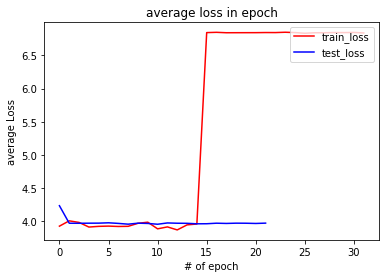

[3.924432695091309, 4.004643426376695, 3.9806692019149796, 3.910972151617588, 3.921402611010292, 3.9252466172607634, 3.9196329990863323, 3.921858254980778, 3.9673746497843903, 3.9840363038100355, 3.883838101877731, 3.9130653610439934, 3.8676596694628715, 3.9435259159971983, 3.956962820041622, 6.844919144648824, 6.849129601979174, 6.842852965125191, 6.8433496041808715, 6.8437159516688855, 6.844034762090696, 6.845809745012538, 6.845332812497534, 6.850287236892025, 6.845163909770509, 6.835036052401522, 6.842602272095349, 6.842819871212537, 6.845463018701197, 6.845054552741386, 6.847159855395785, 6.839651677271233]


In [ ]:
fig = plt.figure()
plt.plot(all_loss, 'r', label='train_loss')
plt.plot(test_loss, 'b', label='test_loss')
plt.legend(loc='upper right')
plt.title('average loss in epoch')
plt.xlabel('# of epoch')
plt.ylabel('average Loss')
plt.show()
print(all_loss)

In [ ]:
import scipy.io as sio

In [ ]:
len(test_loss)


22

In [ ]:
train_loss = all_loss[10:]

In [ ]:
len(train_loss)

22

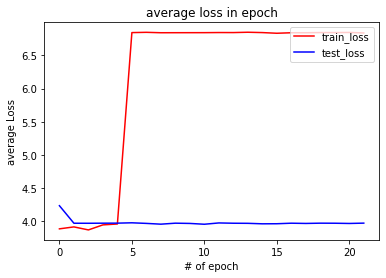

In [ ]:
fig = plt.figure()
plt.plot(train_loss, 'r', label='train_loss')
plt.plot(test_loss, 'b', label='test_loss')
plt.legend(loc='upper right')
plt.title('average loss in epoch')
plt.xlabel('# of epoch')
plt.ylabel('average Loss')
plt.show()

In [ ]:
sio.savemat('matrices.mat', {'train': train_loss, 'test': test_loss})